## 1. Visualizations

In [3]:
! pip install -Uq matplotlib spacy torchdata

In [1]:
from utils_model import subsequent_mask, PositionalEncoding
import matplotlib.pyplot as plt
import torch
from optimize import NoamOpt, LabelSmoothing, SimpleLoss
from transformer import make_model, EncoderDecoder
from train import run_epoch, data_gen

NameError: name 'NoamOpt' is not defined

In [ ]:
?torch.pad

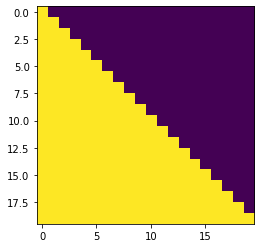

In [2]:
# Token masking
plt.imshow(subsequent_mask(20)[0])
None

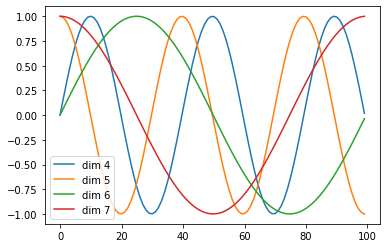

In [3]:
# Positional encoding
pe = PositionalEncoding(d_model=20)
y = pe(torch.zeros(1, 100, 20))

plt.plot(torch.arange(100), y[0, :, 4:8])
plt.legend([f"dim {p}" for p in range(4, 8)])
None

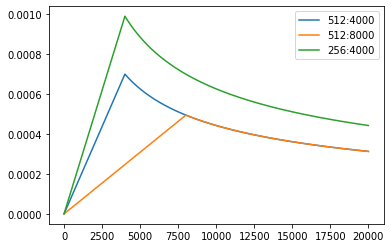

In [4]:
# Noam learning rate scheduler

h_params = ((512, 4000), (512, 8000), (256, 4000))
opts = [
    NoamOpt(d_model=d_model, factor=1, n_warmup_steps=steps, optimizer=None)
    for d_model, steps in h_params
]

plt.plot(torch.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend([f"{d_model}:{steps}" for d_model, steps in h_params])
None

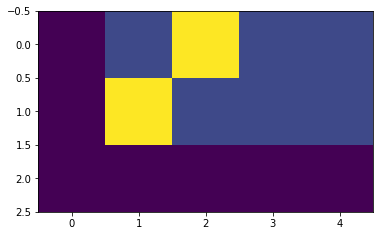

In [5]:
# Label smoothing
crit = LabelSmoothing(n_classes=5, padding_idx=0, smoothing=0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0] for _ in range(3)])
v = crit(predict.log(), torch.LongTensor([2, 1, 0]))

plt.imshow(crit.true_dist)
None

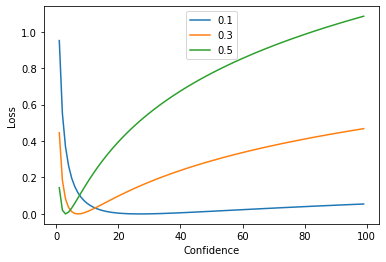

In [6]:
def loss(x, smoothing=0.1):
    crit = LabelSmoothing(5, 0, smoothing)
    
    d = x + 3
    predict = torch.FloatTensor([[0, x/d, 1/d, 1/d, 1/d]])
    
    return crit(predict.log(), torch.LongTensor([1])).item()

smoothing = (0.1, 0.3, 0.5)
plt.plot(torch.arange(1, 100), [[loss(x, s) for s in smoothing] for x in range(1, 100)])
plt.legend(smoothing)
plt.ylabel("Loss")
plt.xlabel("Confidence")
None

## 2. Training the copy task

In [2]:
n_vocab = 11

In [3]:
criterion = LabelSmoothing(n_classes=n_vocab, padding_idx=0, smoothing=0.)

model = make_model(n_vocab, n_vocab, n_layers=2)
model_opt = NoamOpt(
    model.src_embed[0].d_model,
    factor=1,
    n_warmup_steps=400,
    optimizer=torch.optim.Adam(model.parameters(), lr=0., betas=(0.9, 0.98), eps=1e-9))

In [4]:
loss_fn = SimpleLoss(model.generator, criterion, model_opt)
loss_fn_validate = SimpleLoss(model.generator, criterion, None)

for epoch in range(10):
    model.train()
    fake_data = data_gen(n_vocab, batch_size=30, n_batches=20)
    run_epoch(fake_data, model, loss_fn)
    
    with torch.no_grad():
        model.eval()
        fake_valid = data_gen(n_vocab, batch_size=30, n_batches=5)
        results = run_epoch(fake_valid, model, loss_fn_validate)

Epoch step: 1 | Loss (per token): 3.230487823486328 | Tokens per sec: 576.2215576171875
Epoch step: 1 | Loss (per token): 1.925425410270691 | Tokens per sec: 8546.7548828125
Epoch step: 1 | Loss (per token): 2.021913766860962 | Tokens per sec: 109.04007720947266
Epoch step: 1 | Loss (per token): 1.6818645000457764 | Tokens per sec: 2840.557373046875
Epoch step: 1 | Loss (per token): 1.6941957473754883 | Tokens per sec: 660.8679809570312
Epoch step: 1 | Loss (per token): 1.2425199747085571 | Tokens per sec: 2921.171142578125
Epoch step: 1 | Loss (per token): 1.353155255317688 | Tokens per sec: 663.7474975585938
Epoch step: 1 | Loss (per token): 0.9665734171867371 | Tokens per sec: 2998.8349609375
Epoch step: 1 | Loss (per token): 1.2229028940200806 | Tokens per sec: 679.1832885742188
Epoch step: 1 | Loss (per token): 0.6694009900093079 | Tokens per sec: 2963.869873046875
Epoch step: 1 | Loss (per token): 0.8456608653068542 | Tokens per sec: 67.49715423583984
Epoch step: 1 | Loss (per to

In [3]:
if False:
    state_dict = torch.load('models/copy_10_epochs.pt')
    model = make_model(n_vocab, n_vocab, n_layers=2)
    model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
model.eval()
seq_len = 10
with torch.no_grad():
    src = torch.empty(1, seq_len, dtype=torch.long)
    src[0, 0] = 1
    src[0, 1:] = torch.randint(2, n_vocab, size=(1, seq_len - 1))
    src_mask = torch.ones(1, 1, seq_len, dtype=torch.bool)
    output = model.greedy_decode(src, src_mask, n_ctx=seq_len, start_token=1)
    print(torch.cat((src, output)))

tensor([[1, 2, 5, 3, 6, 8, 2, 2, 6, 4],
        [1, 2, 5, 3, 6, 8, 2, 2, 6, 4]])


## To the real world

In [2]:
! pip install -Uq spacy
! python -m spacy download en_core_web_sm
! python -m spacy download de_core_news_sm

     |████████████████████████████████| 12.8 MB 13.8 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 14.6 MB 13.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [13]:
from torchtext import data, datasets
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from utils_training import get_loader
import spacy

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

ImportError: cannot import name 'get_loader' from 'utils_training' (/workspace/annotated-transformer/utils_training.py)

In [11]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def build_vocab():
    train_iter, val_iter, test_iter = datasets.Multi30k(language_pair=('de', 'en'))
    train_iter_map, valid_iter_map = get_loader(train_iter), get_loader(val_iter)

    BOS_TOKEN = '<s>'
    EOS_TOKEN = '</s>'
    BLANK_WORD = '<blank>'
    UNK_WORD = '<unk>'

    de_vocab_iter, en_vocab_iter = zip((tokenize_de(de), tokenize_en(en)) for de, en in train + val + test)

    vocab_src = build_vocab_from_iterator(
        de_vocab_iter,
        min_freq=2,
        specials=[BOS_TOKEN, EOS_TOKEN, BLANK_WORD, UNK_WORD],
    )

    vocab_tgt = build_vocab_from_iterator(
        en_vocab_iter,
        min_freq=2,
        specials=[BOS_TOKEN, EOS_TOKEN, BLANK_WORD, UNK_WORD]
    )

    vocab_src.set_default_index(vocab_src[UNK_WORD])
    vocab_tgt.set_default_index(vocab_tgt[UNK_WORD])

    torch.save((vocab_src, vocab_tgt), 'vocab.pt')
    
    return vocab_src, vocab_tgt

In [12]:
vocab_src, vocab_tgt = build_vocab()

NameError: name 'get_loader' is not defined

In [ ]:
def collate_fn(batch):
    return collate_batch(
        batch,
        tokenize_de,
        tokenize_en,
        vocab_src,
        vocab_tgt,
        device,
        n_ctx=n_ctx,
    )

In [19]:
len(vocab_src)

8315

In [23]:
vocab_tgt[BOS_TOKEN]

0